In [1]:
# https://covidtracking.com/data/download
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
os.makedirs('plots/state', exist_ok=True)
plt.style.use('ggplot')
mpl.rcParams['axes.titlesize'] = 36
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize']=12
mpl.rcParams['ytick.labelsize']=12
mpl.rcParams['legend.fontsize']=12

df = pd.read_csv('daily.csv')
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df = df.rename(columns={'state': 'stateAbbreviation'})
state_abbreviations = pd.read_csv('state_abbreviations.csv')
df = pd.merge(left=df, right=state_abbreviations, on='stateAbbreviation')
pop_df = pd.read_csv('nst-est2019-alldata.csv')
pop_df = pop_df.loc[:,['NAME', 'POPESTIMATE2019']].rename(columns={'NAME': 'stateName', 'POPESTIMATE2019': 'population'})
pop_df['stateNameShort'] = pop_df['stateName'].str.replace(' ', '')
df = pd.merge(left=df, right=pop_df, on='stateNameShort')
df['hospitalizedCurrentlyPercent'] = df['hospitalizedCurrently']/df['population']
df['hospitalizedCumulativePercent'] = df['hospitalizedCumulative']/df['population']
df['hospitalizedIncreasePercent'] = df['hospitalizedIncrease']/df['population']
df['deathPercent'] = df['death']/df['population']
df['deathIncreasePercent'] = df['deathIncrease']/df['population']
df['positivePercent'] = df['positive']/df['population']
df['positiveIncreasePercent'] = df['positiveIncrease']/df['population']
df['totalTestResultsIncreasePercent'] = df['totalTestResultsIncrease']/df['population']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6116 entries, 0 to 6115
Data columns (total 50 columns):
date                               6116 non-null datetime64[ns]
stateAbbreviation                  6116 non-null object
positive                           6116 non-null float64
negative                           6014 non-null float64
pending                            745 non-null float64
hospitalizedCurrently              4027 non-null float64
hospitalizedCumulative             3450 non-null float64
inIcuCurrently                     2013 non-null float64
inIcuCumulative                    906 non-null float64
onVentilatorCurrently              1736 non-null float64
onVentilatorCumulative             318 non-null float64
recovered                          3456 non-null float64
dataQualityGrade                   5200 non-null object
lastUpdateEt                       5768 non-null object
dateModified                       5768 non-null object
checkTimeEt                        576

In [2]:
def plot_state(df, state, important_dates=None, show=True, plot_tests=False):
    df = df.loc[df['stateName']==state]
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    ax.plot(df['date'], df['positiveIncreasePercent'], color='blue', linestyle='--', label='new cases (% of pop)')
    ax.plot(df['date'], df['positivePercent'], color='blue', linestyle='-', label='total cases (% of pop)')
    ax.plot(df['date'], df['deathIncreasePercent'], color='red', linestyle='--', label='new deaths (% of pop)')
    ax.plot(df['date'], df['deathPercent'], color='red', linestyle='-', label='total deaths (% of pop)')
    if plot_tests:
        ax.plot(df['date'], df['totalTestResultsIncreasePercent']/10**3, color='green', linestyle='--', label='new tests (% of pop)')
    if important_dates is not None:
        for d in important_dates:
            ax.axvline(d, color='black', linestyle='--')
    ax.set_yscale('log')
    ax.set_title(state)
    ax.set_xlabel('Date')
    ax.set_ylabel('Percent of Population')
    ax.legend()
    fig.savefig(f'plots/state/{state.lower().replace(" ", "_")}.png')
    if show:
        plt.show()

c:\users\scott\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


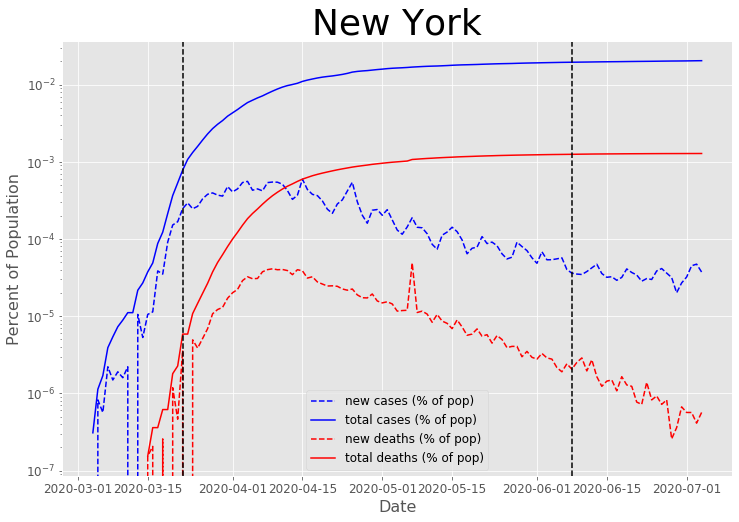

In [3]:
plot_state(df, 'New York', ['3/22/2020', '6/8/2020'])

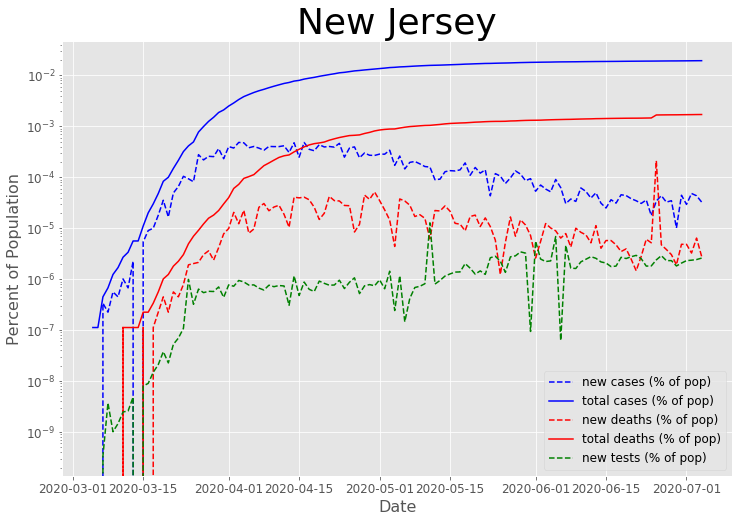

In [62]:
plot_state(df, 'New Jersey', plot_tests=True)

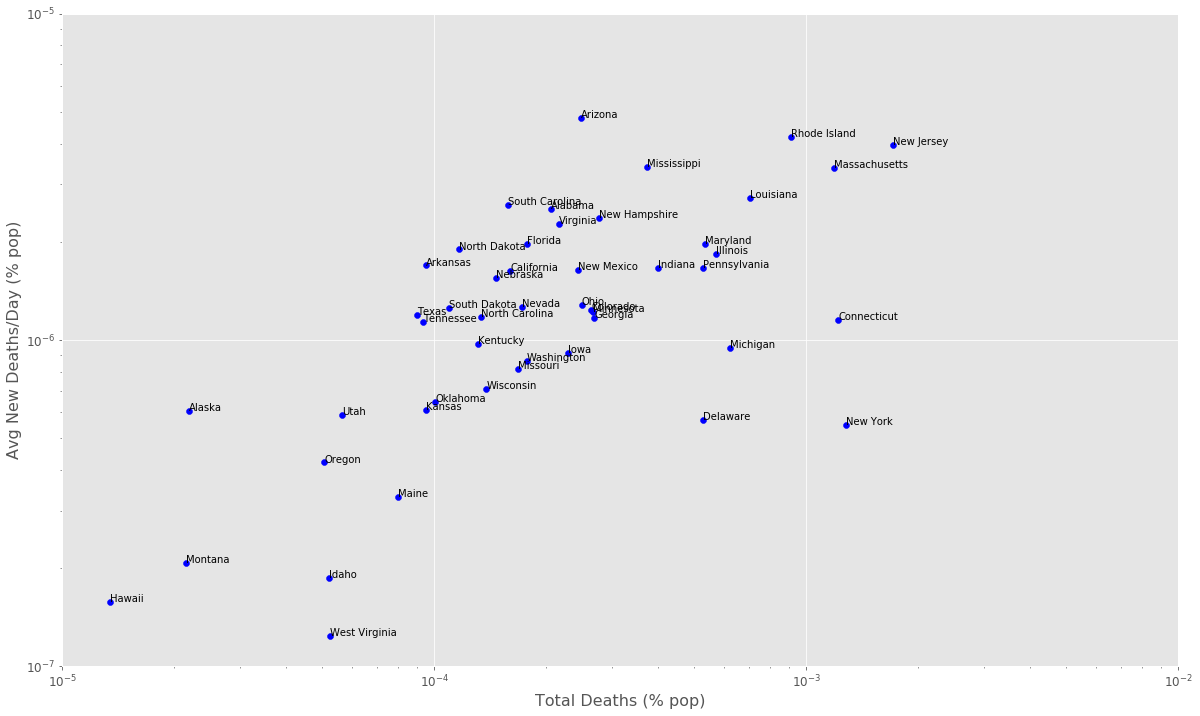

In [59]:
total_deaths = df.groupby(['stateName'])['deathPercent'].max().reset_index()
recent = df.loc[df['date']>=pd.to_datetime('6/26/2020')]
recent_new_deaths = recent.groupby(['stateName'])['deathIncreasePercent'].mean().reset_index()
deaths = pd.merge(left=total_deaths, right=recent_new_deaths, on=['stateName'])

fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111)
ax.scatter(deaths['deathPercent'], deaths['deathIncreasePercent'], color='blue')
ax.set_xlim([1e-5, 1e-2])
ax.set_ylim([1e-7, 1e-5])

ax.set_xlabel('Total Deaths (% pop)')
ax.set_ylabel('Avg New Deaths/Day (% pop)')

labeled_states = deaths['stateName'].unique()
for c in labeled_states:
    x = deaths.loc[deaths['stateName']==c, 'deathPercent'].values[0]
    y = deaths.loc[deaths['stateName']==c, 'deathIncreasePercent'].values[0]
    if x>1e-7 and y>1e-9:
        ax.text(x, y, c)

ax.set_xscale('log')
ax.set_yscale('log')

plt.show()

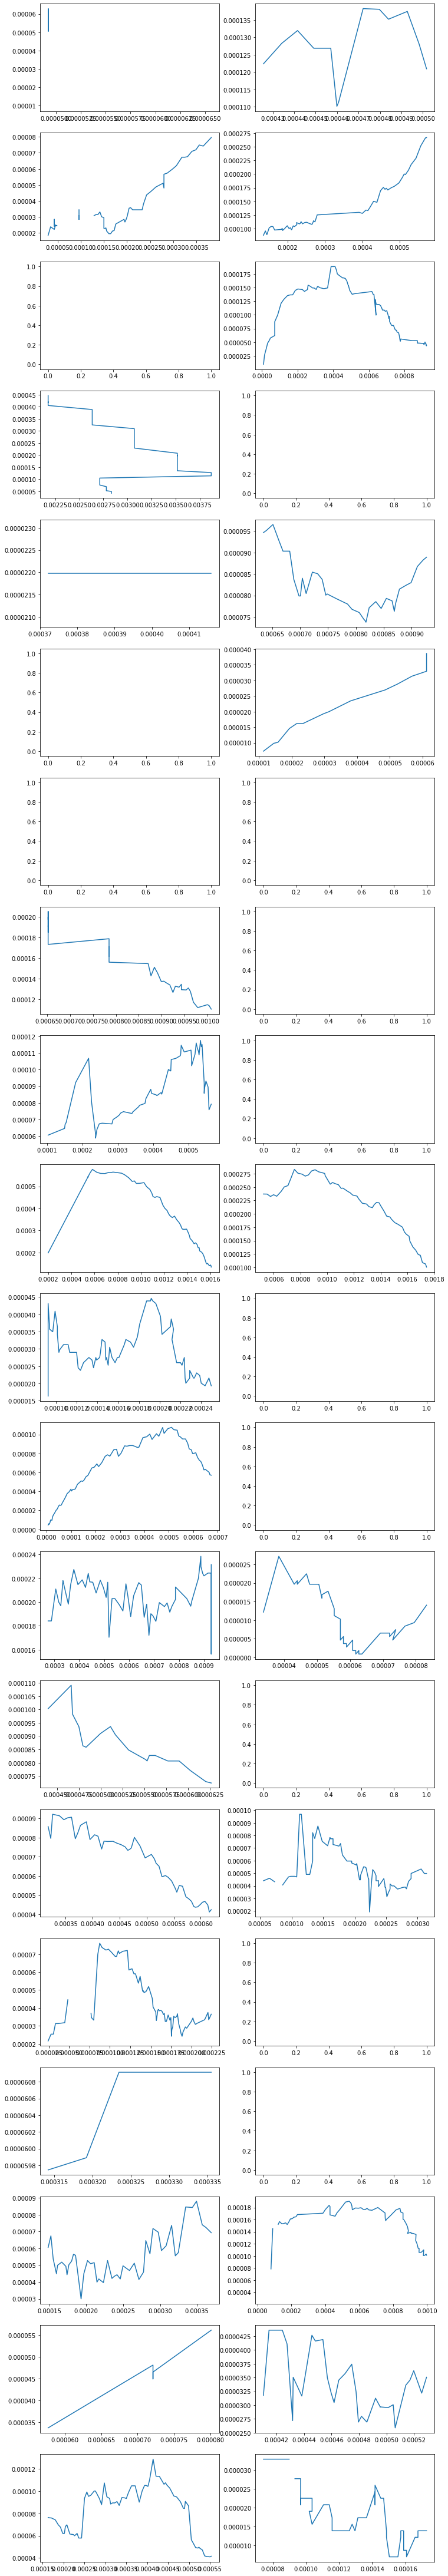

In [87]:
states = df['stateName'].unique()
fig = plt.figure(figsize=(12,100))
for i,state in enumerate(states):
    ax = fig.add_subplot(25, 2, i+1)
    state_df = df.loc[df['stateName']==state,:]
    ax.plot(state_df['hospitalizedCumulativePercent'], state_df['hospitalizedCurrentlyPercent'], label=state)
#ax.set_yscale('log')
#ax.set_xscale('log')
#ax.legend()
plt.show()

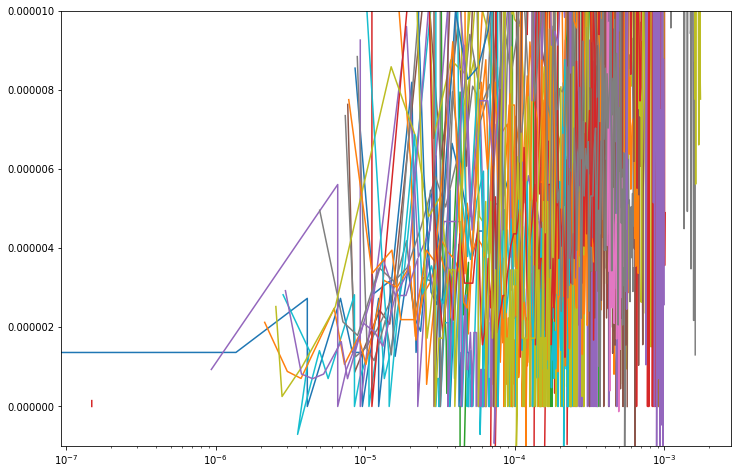

In [79]:
states = df['stateName'].unique()
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
for state in states:
    if state!='Connecticut':
        state_df = df.loc[df['stateName']==state,:]
        ax.plot(state_df['hospitalizedCumulativePercent'], state_df['hospitalizedIncreasePercent'], label=state)
#ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(-.000001, .00001)
#ax.legend()
plt.show()

In [84]:
fig.add_subplot?

0       0
1       0
2       0
3       0
4       0
       ..
4369    0
4370    0
4371    0
4372    0
4373    0
Name: deathIncrease, Length: 4374, dtype: int64


In [30]:
print(pop_df['stateNameShort'].unique())

['United States' 'Northeast Region' 'Midwest Region' 'South Region'
 'West Region' 'Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California'
 'Colorado' 'Connecticut' 'Delaware' 'District of Columbia' 'Florida'
 'Georgia' 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas'
 'Kentucky' 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan'
 'Minnesota' 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada'
 'New Hampshire' 'New Jersey' 'New Mexico' 'New York' 'North Carolina'
 'North Dakota' 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island'
 'South Carolina' 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Vermont'
 'Virginia' 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming'
 'Puerto Rico']
